In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

!pip install elasticdeform

import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from torch import nn
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold, KFold

from deepflash import preproc, unetadaption, utility
from deepflash.fastai_extension import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'

IMAGE_COLOR = 'red'   # 'red','green'

TILE_SHAPE = (540,540)    # desired input size
MASK_SHAPE = (356,356)       # 540-184
EL_SIZE = [635.9, 635.9]

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/{IMAGE_COLOR}'
MASK_PATH = f'{DIR}/temp_data/labels/'
WEIGHT_PATH = f'{DIR}/temp_data/weights/'

# DON'T CHANGE
PADDING = tuple(np.subtract(TILE_SHAPE,MASK_SHAPE))

Training Params

In [0]:
BATCH_SIZE = 2
EPOCHS = 100
N_SPLITS = 10
WEIGHT_DECAY = 0.01

Network Params

In [0]:
IN_CHANNELS = 1
N_CLASSES = 2  #number of classes
DEPTH = 5
BATCH_NORM = False

# Custom Net Overview

In [7]:
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,
                        n_classes=N_CLASSES,
                        depth=DEPTH,
                        batch_norm=BATCH_NORM)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
            Conv2d-8        [-1, 128, 264, 264]         147,584
              ReLU-9        [-1, 128, 264, 264]               0
    UNetConvBlock-10        [-1, 128, 264, 264]               0
           Conv2d-11        [-1, 256, 130, 130]         295,168
             ReLU-12        [-1, 256, 130, 130]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] # get list with img_ids
imgExt = os.path.splitext(filenames[0])[1]                    # get image extension

In [0]:
images = [img_name for img_name in [f'{s}{imgExt}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### Change regDigits if filenames have a different structure

regDigits = '\d{4}'
maskExt = '.tif'
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')

Show example image, labels and weights

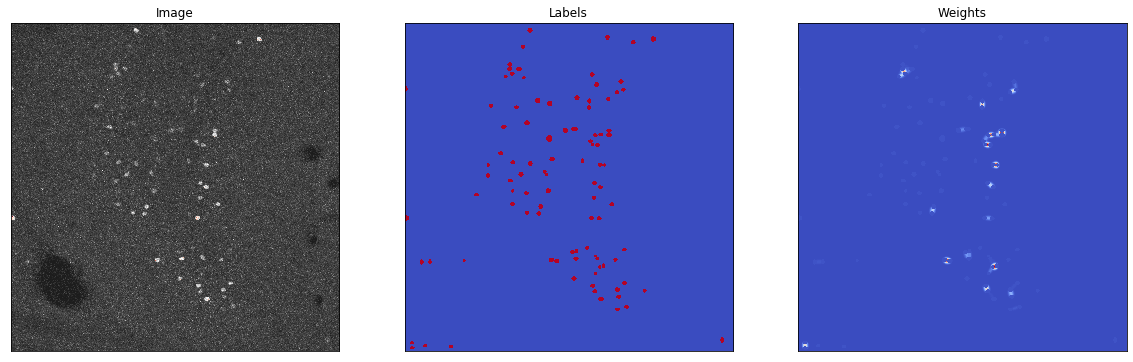

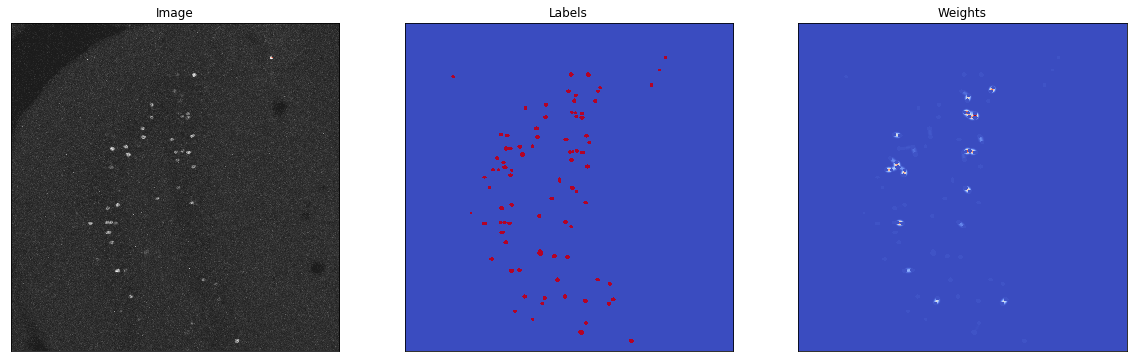

In [11]:
# cmap can be either string or list of strings
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights,cmap=('RdGy_r','coolwarm','coolwarm'), n=2)

Calculate the row and col percentage for random crop

In [0]:
original_size = utility.get_image_size(f'{IMG_PATH}/{img_ids[0]}{imgExt}')

row_col_per = np.divide(np.add(np.multiply(0.5,TILE_SHAPE),1),original_size)

rand_pos = {'row_pct':(row_col_per[0],1-row_col_per[0]), 'col_pct':(row_col_per[1],1-row_col_per[1])}

In [0]:
def _crop_pad(x, size, padding_mode='reflection', row_pct:uniform = 0.5, col_pct:uniform = 0.5):
    f_crop_pad = _crop_pad_image_points if isinstance(x, ImagePoints) else _crop_pad_default
    return f_crop_pad(x, size, padding_mode, row_pct, col_pct)

first_crop = TfmCrop(_crop_pad, order=0)

In [14]:
def first_rand_crop(*args, rand_pos = rand_pos, padding_mode='zeros', p:float=1.):
    "Randomized version of `crop_pad`."
    return first_crop(*args, **rand_pos, padding_mode=padding_mode, p=p)

first_rand_crop()


RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.2646484375, 0.7353515625), 'col_pct': (0.2646484375, 0.7353515625), 'padding_mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)

# Create Databunch object for further training

**Custom 'get_transforms()' function for selected augmentations**

Transforms are generally applied on train set only, but this can be changed with 'transform_valid_ds = True'. Standard transforms on train set include: 

*   randomly mirror image on x- and y-axis
*   light brightness and contrast shift
*   random rotation
*   elastic deformation





In [0]:
tfms = get_custom_transforms(elastic_deformation=False)
#tfms = None

**Create databunch object**

In [31]:
data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode='L')
      # import from df in greyscale ('L')
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True, resize_method=ResizeMethod.CROP,size=TILE_SHAPE, mode = 'nearest')
      # apply data augmentation, 'nearest' to avoid interpolation of the masks
      .databunch(bs=BATCH_SIZE)
      # set batchsize
)

Masks will be cropped to (356, 356). Choose 'None' to keep initial size.
Masks will be cropped to (356, 356). Choose 'None' to keep initial size.


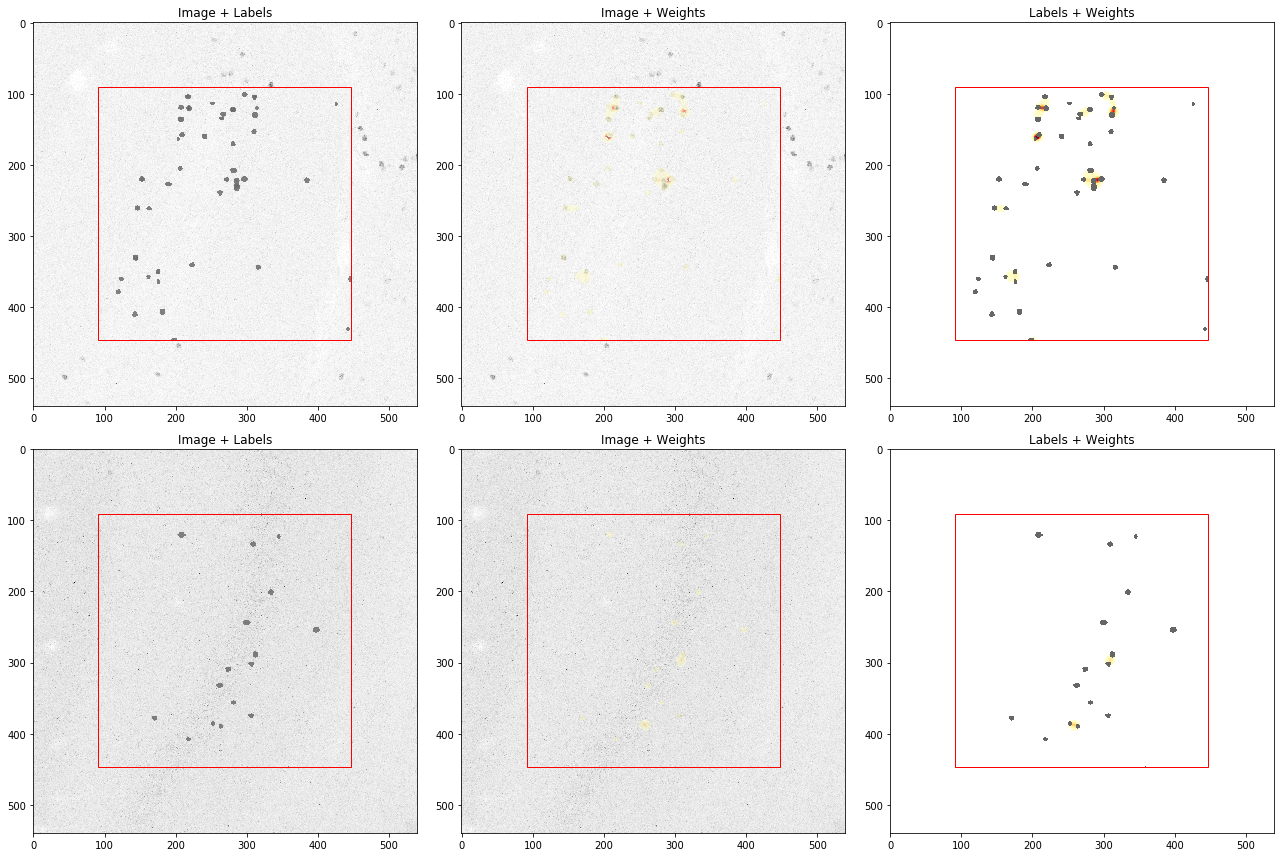

In [32]:
data.show_batch()

## Learner object and Training

Metrics

In [0]:
# metrics_wrapper let's you use any metric for this weighted-labels architecture 
# (get's rid of the weights and passes only labels to metric)
# if 'swap_preds = True' prediction and groundtruth are swapped (useful for sklearn.metrics)
# if 'softmax = True' all predictions will be normalized using nn.Softmax2d

IoU = metrics_wrapper(metric=dice, iou=True)
f1 = metrics_wrapper(metric=fbeta, beta=1)

this Learner object self-destroyed - it still exists, but no longer usable


Learner

In [0]:
learn = Learner(data, 
                net,
                model_dir = DIR,
                opt_func = torch.optim.Adam,
                metrics = [IoU,f1],
                loss_func = WeightedCrossEntropyLoss(axis=1, reduction_mode='mean'),
                callback_fns=ShowGraph,
                wd=WEIGHT_DECAY)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


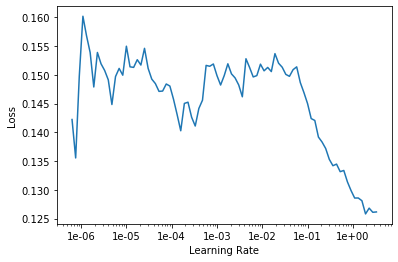

In [35]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

epoch,train_loss,valid_loss,dice,fbeta,time
0,0.121436,0.112390,0.000000,0.040132,00:09
1,0.097909,0.114829,0.000000,0.040132,00:07
2,0.091502,0.105334,0.000000,0.040132,00:08
3,0.087343,0.104427,0.000000,0.040132,00:08
4,0.084301,0.104281,0.000000,0.040132,00:08
5,0.081264,0.103613,0.000000,0.040132,00:07
6,0.080154,0.103466,0.000000,0.040132,00:06
7,0.079638,0.103363,0.000000,0.040132,00:07
8,3313942213344935414293342453760.000000,45626567435513400909805767360512.000000,0.027517,0.040132,00:07
9,5885790752485618975524584947712.000000,3380312543073233459642005192704.000000,0.027515,0.040132,00:07


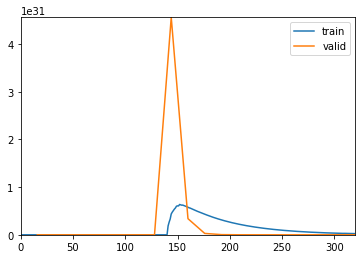

In [36]:
learn.fit_one_cycle(20,max_lr=8e-1)

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [0]:
learn.save('initial-stage')

In [0]:
learn.load('initial-stage')

In [0]:
kfold = KFold(N_SPLITS, True, 42)
count = 0

# enumerate splits
for train, test in kfold.split(img_df):
  
  #print('train: %s, test: %s' % (train, test))

  data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode='L')
      # import from df in greyscale ('L')
      .split_by_idxs(train_idx=train, valid_idx=test)
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True, resize_method=ResizeMethod.CROP,size=TILE_SHAPE, mode = 'nearest')
      # apply data augmentation, 'nearest' to avoid interpolation of the masks
      .databunch(bs=BATCH_SIZE)
      # set batchsize
  )

  learn.data = data

  learn.fit(5,wd=WEIGHT_DECAY)

  

In [0]:
x,y = data.one_batch()